<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-04-14 01:18:47--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-04-14 01:18:47--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-04-14 01:18:48--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

['dolly-parton.txt',
 'lorde.txt',
 'bruno-mars.txt',
 'lady-gaga.txt',
 'amy-winehouse.txt',
 'nursery_rhymes.txt',
 'britney-spears.txt',
 'bjork.txt',
 'r-kelly.txt',
 'nicki-minaj.txt',
 'drake.txt',
 'jimi-hendrix.txt',
 'radiohead.txt',
 'kanye.txt',
 'patti-smith.txt',
 'johnny-cash.txt',
 'Kanye_West.txt',
 'alicia-keys.txt',
 'bob-dylan.txt',
 'dr-seuss.txt',
 'michael-jackson.txt',
 'leonard-cohen.txt',
 'missy-elliott.txt',
 'nickelback.txt',
 'dickinson.txt',
 'adele.txt',
 'paul-simon.txt',
 'al-green.txt',
 'nirvana.txt',
 'lil-wayne.txt',
 'notorious-big.txt',
 'lin-manuel-miranda.txt',
 'janisjoplin.txt',
 'bob-marley.txt',
 'cake.txt',
 'ludacris.txt',
 'rihanna.txt',
 'eminem.txt',
 'Lil_Wayne.txt',
 'beatles.txt',
 'prince.txt',
 'kanye-west.txt',
 'disney.txt',
 'joni-mitchell.txt',
 'blink-182.txt',
 'bieber.txt',
 'notorious_big.txt',
 'bruce-springsteen.txt',
 'dj-khaled.txt']

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

**Consideraremos** que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

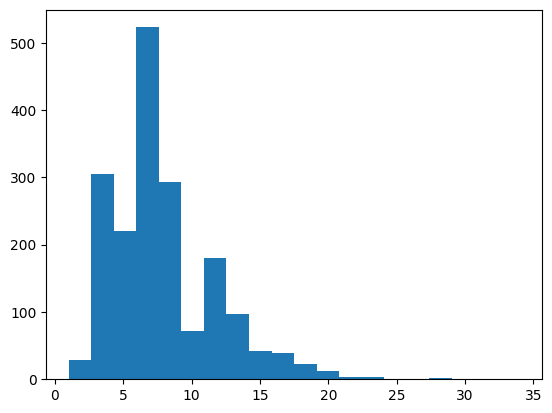

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences

[[200, 10, 12, 907, 908, 42, 909, 121],
 [22, 13, 638, 91, 217, 349, 79, 4, 314],
 [23, 2, 160, 9, 200, 520, 35, 83, 910, 3, 78, 2, 911, 4, 15],
 [173, 7, 912, 913, 397, 8],
 [23, 200, 218, 520, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200],
 [175,
  175,
  175,
  175,
  175,
  175,
  175,
  36,
  2,
  230,
  522,
  9,
  398,
  17,
  914,
  639,
  640,
  133,
  4,
  8],
 [447, 162, 17, 315, 29, 13, 15],
 [5, 9, 12, 915, 17, 916, 19, 20, 189, 74, 9, 917, 17, 8],
 [447, 162, 17, 315, 29, 13, 15],
 [29, 13, 15, 29, 13, 15, 29, 13, 15, 29, 13, 15],
 [448, 162, 17, 315, 29, 13, 15, 5, 36, 3, 399, 918, 107, 3

In [ ]:
max_context_size+1

13

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(15325, 13)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'far': 1, 'seemed': 1, 'my': 134, 'yesterday': 10, 'troubles': 1, 'so': 61, 'all': 177, 'away': 21, 'here': 33, 'though': 11, 'as': 25, 'stay': 7, 'it': 125, 'to': 307, "they're": 5, 'looks': 2, 'now': 90, 'i': 400, 'in': 186, 'suddenly': 3, 'half': 1, 'be': 108, 'not': 32, 'used': 1, 'believe': 15, 'man': 34, "i'm": 66, 'the': 376, 'oh': 77, 'hanging': 1, "there's": 14, 'shadow': 1, 'me': 219, 'over': 5, 'a': 270, 'she': 90, 'had': 19, "don't": 74, "wouldn't": 4, 'why': 20, 'know': 132, 'say': 76, 'go': 38, 'came': 11, 'wrong': 6, 'love': 181, 'was': 48, 'such': 9, 'long': 25, 'an': 15, 'said': 14, 'something': 13, 'easy': 9, 'for': 62, 'play': 10, 'game': 3, 'hide': 13, 'place': 10, 'need': 51, 'times': 5, 'trouble': 1, 'find': 10, 'comes': 20, 'of': 109, 'mother': 2, 'when': 71, 'mm': 3, 'mary': 2, 'myself': 3, 'wisdom': 7, 'words': 14, 'speaking': 4, 'let': 55, 'front': 1, 'is': 89, 'standing': 13, 'right': 25, 'and': 311, 'hour': 1, 'darkness': 1, 'brok


### Definir el modelo

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 5)             8145      
                                                                 
 lstm (LSTM)                 (None, 12, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1629)              53757     
                                                                 
Total params: 114926 (448.93 KB)
Trainable params: 11492

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
476/479 [============================>.] - ETA: 0s - loss: 5.9964
 mean perplexity: 1861.701724492084 

479/479 [==============================] - 41s 70ms/step - loss: 5.9974
Epoch 2/50
476/479 [============================>.] - ETA: 0s - loss: 5.6672
 mean perplexity: 3614.040795512048 

479/479 [==============================] - 27s 56ms/step - loss: 5.6672
Epoch 3/50
474/479 [============================>.] - ETA: 0s - loss: 5.4381
 mean perplexity: 6331.428218628087 

479/479 [==============================] - 25s 52ms/step - loss: 5.4392
Epoch 4/50
473/479 [============================>.] - ETA: 0s - loss: 5.2428
 mean perplexity: 19002.597285342217 

479/479 [==============================] - 26s 54ms/step - loss: 5.2407
Epoch 5/50
475/479 [============================>.] - ETA: 0s - loss: 5.0632
 mean perplexity: 74026.66368990585 

479/479 [==============================] - 25s 52ms/step - loss: 5.0614
Epoch 6/50
476/479 [============================>.] - ETA: 0s - 

<ipython-input-26-4af0c4d597ea>:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

479/479 [==============================] - 26s 53ms/step - loss: 3.4900
Epoch 29/50
475/479 [============================>.] - ETA: 0s - loss: 3.4440
 mean perplexity: inf 

479/479 [==============================] - 25s 52ms/step - loss: 3.4461
Epoch 30/50
474/479 [============================>.] - ETA: 0s - loss: 3.3990
 mean perplexity: inf 

479/479 [==============================] - 26s 54ms/step - loss: 3.4008
Epoch 31/50
474/479 [============================>.] - ETA: 0s - loss: 3.3584
 mean perplexity: inf 

479/479 [==============================] - 25s 53ms/step - loss: 3.3583
Epoch 32/50
473/479 [============================>.] - ETA: 0s - loss: 3.3131
 mean perplexity: inf 

479/479 [==============================] - 25s 52ms/step - loss: 3.3154
Epoch 33/50
476/479 [============================>.] - ETA: 0s - loss: 3.2778
 mean perplexity: inf 

479/479 [==============================] - 27s 56ms/step - loss: 3.2774
Epoch 34/50
472/479 [============

In [ ]:
print(hist.history)

{'loss': [5.997411727905273, 5.6671905517578125, 5.439243793487549, 5.240692615509033, 5.061354637145996, 4.931539535522461, 4.82350492477417, 4.735884189605713, 4.65577507019043, 4.587841510772705, 4.514212608337402, 4.445767879486084, 4.379019260406494, 4.312806606292725, 4.2474212646484375, 4.18088960647583, 4.117079734802246, 4.048126220703125, 3.9776358604431152, 3.906712532043457, 3.847014904022217, 3.786794662475586, 3.7313544750213623, 3.6757638454437256, 3.624438762664795, 3.572282075881958, 3.5293221473693848, 3.4899728298187256, 3.4461281299591064, 3.4008381366729736, 3.3583438396453857, 3.31535005569458, 3.2774264812469482, 3.2454867362976074, 3.2103142738342285, 3.1704487800598145, 3.132999897003174, 3.10553240776062, 3.065711736679077, 3.046276807785034, 3.010683536529541, 2.9884865283966064, 2.952174663543701, 2.9340736865997314, 2.9069437980651855, 2.8792176246643066, 2.8608527183532715, 2.8315584659576416, 2.804368734359741, 2.7891690731048584]}


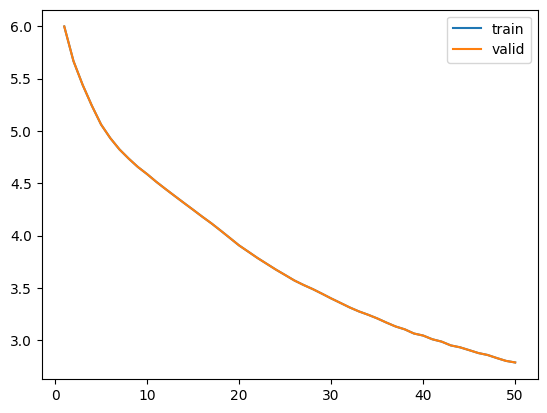

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='valid')
plt.show()





### Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://fd5dda7a82e44c4959.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 19ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fd5dda7a82e44c4959.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 23ms/step


"hey jude don't know you"

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times")

1/1 [==============================] - 0s 20ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['when i find myself in times of trouble mother mary comes right']

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

## Consigna

Paso la consigna para que quede clara:
- Entrenar un modelo de lenguaje basado en arquitectura recurrente, utilizando un corpus mayor al utilizado en clase.
- Explorar diferentes variantes de arquitecturas (GRU, LSTM, Bidireccionales, Cantidad de capas y neuronas, tamaño de contexto máximo)
- El objetivo principal sería lograr que durante el entrenamiento baje la perplejidad.
- Con el modelo que les haya resultado mejor, realizar algunas pruebas de generación de secuencias utilizando greedy search, beam search determinista y beam search estocástico (aquí pueden incluso variar la temperatura).

# Alumno - Resolución

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Importamos dataset

Importamos el corpus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Información del Corpus: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

Usability
7.94

License
CC0: Public Domain

In [ ]:
# Descargar la carpeta de dataset
import os
import platform

!pwd
if os.access('./Reviews.csv', os.F_OK) is False or os.access('./hashes.txt', os.F_OK) is False or os.access('./database.sqlite', os.F_OK) is False:
  !unzip -q /content/drive/MyDrive/Maestria/NLP/Amazon_Fine_Food_Reviews.zip
else:
    print("El dataset ya se encuentra descargado")

/content


In [ ]:
# Posibles bandas
os.listdir("./")

['.config',
 'database.sqlite',
 'hashes.txt',
 'Reviews.csv',
 'drive',
 'sample_data']

In [ ]:
# prompt: read ./Reviews.csv and put it into a df

import pandas as pd
df_ = pd.read_csv('./Reviews.csv')

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df_.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Ahora vamos entrenar dos modelos para las reviews de 1 estrella: Usando LSTM, y usando GRU

In [ ]:
print("Cantidad de documentos:", df_.shape[0])

Cantidad de documentos: 568454


In [ ]:
#Me voy a quedar solo con la columna Text y las reviews que son apriori malas
df=df_[df_['Score'] == 1]['Text'].to_frame()

In [ ]:
df.head(30)

,Text
1,Product arrived labeled as Jumbo Salted Peanut...
12,My cats have been happily eating Felidae Plati...
26,"The candy is just red , No flavor . Just plan..."
50,"This oatmeal is not good. Its mushy, soft, I d..."
62,Arrived in 6 days and were so stale i could no...
73,Buyer Beware Please! This sweetener is not for...
75,No tea flavor at all. Just whole brunch of art...
99,I fed this to my Golden Retriever and he hated...
153,These singles sell for $2.50 - $3.36 at the st...
164,Seriously this product was as tasteless as the...


**Consideraremos** que cada secuencia para este dataset es una review.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 52268


Dado a que es un tamaño demasiado grande, procede a quedarme menos elementos

In [ ]:
df.head()

,Text
1,Product arrived labeled as Jumbo Salted Peanut...
12,My cats have been happily eating Felidae Plati...
26,"The candy is just red , No flavor . Just plan..."
50,"This oatmeal is not good. Its mushy, soft, I d..."
62,Arrived in 6 days and were so stale i could no...


In [ ]:
df['Len'] = [len(x) for x in df['Text']]

In [ ]:
df.head()

,Text,Len
1,Product arrived labeled as Jumbo Salted Peanut...,190
12,My cats have been happily eating Felidae Plati...,399
26,"The candy is just red , No flavor . Just plan...",88
50,"This oatmeal is not good. Its mushy, soft, I d...",89
62,Arrived in 6 days and were so stale i could no...,71


Me quedo solo con el 10% de las secuencias mas cortas

In [ ]:
df = df.sort_values(by=['Len'],ascending=True)[:int(len(df)*0.1)]

In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 5226


Ahora tiene un valor mas adecuado

In [ ]:
df.head()

,Text,Len
453668,Not worth it,12
478143,I'm not happy with it as I didn't even receive...,50
33827,This coffee was very bitter. Not my cup of co...,50
528855,This is so good I wish it comes in a bigger pa...,52
449435,Awful taste it was soft and airy I fed it to m...,53


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
print(df.iloc[:,0])

453668                                         Not worth it
478143    I'm not happy with it as I didn't even receive...
33827     This coffee was very bitter.  Not my cup of co...
528855    This is so good I wish it comes in a bigger pa...
449435    Awful taste it was soft and airy I fed it to m...
                                ...                        
494016    The milk would not completely flow properly (s...
61655     This was the worst loose tea I have ever had. ...
7769      $136 for 12 boxes?<br /><br />Is this a rare i...
324606    I bought this reading good reviews about the f...
111969    Ordered these as a plan for a party. They were...
Name: Text, Length: 5226, dtype: object


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])
print(len(text))

5226


In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   3.,   0.,   4.,   0.,  56.,  62.,   0., 145., 163.,   0.,
        150.,   0., 121., 221.,   0., 596.,   0., 618., 687.,   0., 650.,
        546.,   0., 450.,   0., 338., 218.,   0., 112.,  54.,   0.,  12.,
          0.,   7.,   9.,   0.,   0.,   1.]),
 array([ 3.  ,  3.62,  4.24,  4.86,  5.48,  6.1 ,  6.72,  7.34,  7.96,
         8.58,  9.2 ,  9.82, 10.44, 11.06, 11.68, 12.3 , 12.92, 13.54,
        14.16, 14.78, 15.4 , 16.02, 16.64, 17.26, 17.88, 18.5 , 19.12,
        19.74, 20.36, 20.98, 21.6 , 22.22, 22.84, 23.46, 24.08, 24.7 ,
        25.32, 25.94, 26.56, 27.18, 27.8 , 28.42, 29.04, 29.66, 30.28,
        30.9 , 31.52, 32.14, 32.76, 33.38, 34.  ]),
 <BarContainer object of 50 artists>)

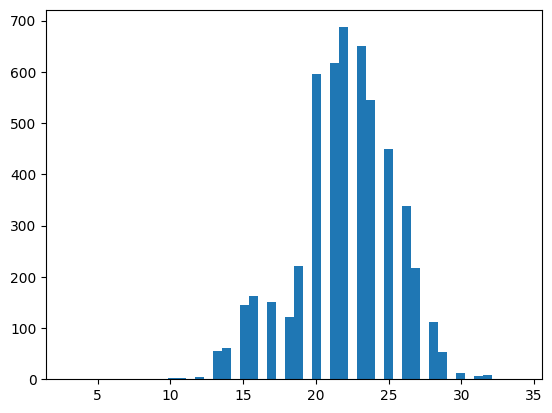

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=50)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 25


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences

[[6, 148, 4],
 [166, 6, 272, 29, 4, 43, 1, 101, 68, 429, 4],
 [3, 38, 11, 25, 149, 6, 16, 130, 10, 38],
 [3, 9, 47, 35, 1, 249, 4, 533, 13, 7, 2530, 169],
 [122, 17, 4, 11, 566, 5, 1612, 1, 994, 4, 8, 16, 136],
 [122, 17, 4, 11, 566, 5, 1612, 1, 994, 4, 8, 16, 136],
 [122, 17, 4, 11, 566, 5, 1612, 1, 994, 4, 8, 16, 136],
 [122, 17, 4, 11, 566, 5, 1612, 1, 994, 4, 8, 16, 136],
 [122, 17, 4, 11, 566, 5, 1612, 1, 994, 4, 8, 16, 136],
 [2531, 1473, 159, 17, 6, 7, 490, 14, 269, 2532, 1348],
 [1821, 2102, 583, 2533, 114, 491, 2534, 36, 36, 1821],
 [53, 116, 127, 3, 9, 256, 43, 1, 63, 224, 3, 78],
 [53, 116, 127, 3, 9, 256, 43, 1, 63, 224, 3, 78],
 [53, 116, 127, 3, 9, 256, 43, 1, 63, 224, 3, 78],
 [1, 293, 8, 24, 8, 234, 3, 15, 81, 61, 6, 14, 31, 22, 27],
 [1, 24, 6, 92, 3, 78, 1, 811, 8, 14, 4, 69, 1, 46],
 [48, 9, 211, 39, 256, 127, 9, 7, 177, 257, 113, 10, 170, 47, 80],
 [1, 2103, 72, 7, 114, 257, 1613, 10, 123, 207, 12, 782, 178, 13, 3329, 1614],
 [3, 21, 226, 8, 54, 1254, 13, 227, 6, 21

In [ ]:
max_context_size+1

26

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

4767

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(101991, 26)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'this',
 4: 'it',
 5: 'and',
 6: 'not',
 7: 'a',
 8: 'to',
 9: 'is',
 10: 'of',
 11: 'was',
 12: 'for',
 13: 'in',
 14: 'like',
 15: 'but',
 16: 'my',
 17: 'taste',
 18: 'these',
 19: 'they',
 20: 'you',
 21: 'product',
 22: 'at',
 23: 'are',
 24: 'have',
 25: 'very',
 26: 'buy',
 27: 'all',
 28: 'that',
 29: 'with',
 30: 'would',
 31: 'them',
 32: 'be',
 33: 'had',
 34: 'no',
 35: 'good',
 36: 'br',
 37: 'just',
 38: 'coffee',
 39: 'on',
 40: 'again',
 41: 'one',
 42: 'will',
 43: 'as',
 44: 'flavor',
 45: 'were',
 46: 'do',
 47: 'so',
 48: 'what',
 49: 'money',
 50: 'from',
 51: 'has',
 52: 'if',
 53: "don't",
 54: 'me',
 55: 'can',
 56: 'out',
 57: 'get',
 58: 'or',
 59: 'price',
 60: 'tastes',
 61: 'did',
 62: 'your',
 63: 'never',
 64: 'box',
 65: 'too',
 66: 'bad',
 67: 'only',
 68: 'even',
 69: 'when',
 70: 'tasted',
 71: 'eat',
 72: 'up',
 73: 'tea',
 74: 'waste',
 75: 'away',
 76: 'order',
 77: "it's",
 78: 'item',
 79: 'dog',
 80: 'much',
 81: 'we',
 8

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

5870

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'i': 1, 'the': 2, 'this': 3, 'it': 4, 'and': 5, 'not': 6, 'a': 7, 'to': 8, 'is': 9, 'of': 10, 'was': 11, 'for': 12, 'in': 13, 'like': 14, 'but': 15, 'my': 16, 'taste': 17, 'these': 18, 'they': 19, 'you': 20, 'product': 21, 'at': 22, 'are': 23, 'have': 24, 'very': 25, 'buy': 26, 'all': 27, 'that': 28, 'with': 29, 'would': 30, 'them': 31, 'be': 32, 'had': 33, 'no': 34, 'good': 35, 'br': 36, 'just': 37, 'coffee': 38, 'on': 39, 'again': 40, 'one': 41, 'will': 42, 'as': 43, 'flavor': 44, 'were': 45, 'do': 46, 'so': 47, 'what': 48, 'money': 49, 'from': 50, 'has': 51, 'if': 52, "don't": 53, 'me': 54, 'can': 55, 'out': 56, 'get': 57, 'or': 58, 'price': 59, 'tastes': 60, 'did': 61, 'your': 62, 'never': 63, 'box': 64, 'too': 65, 'bad': 66, 'only': 67, 'even': 68, 'when': 69, 'tasted': 70, 'eat': 71, 'up': 72, 'tea': 73, 'waste': 74, 'away': 75, 'order': 76, "it's": 77, 'item': 78, 'dog': 79, 'much': 80, 'we': 81, 'ever': 82, 'really': 83, 'love': 84, 'got': 85, '2': 86, 'more': 87, 'bought': 88

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'it': 2081, 'not': 1951, 'worth': 118, 'receive': 34, "didn't": 176, 'even': 268, 'i': 2825, 'happy': 53, 'with': 546, 'as': 339, "i'm": 99, 'bitter': 104, 'of': 1512, 'very': 598, 'cup': 121, 'was': 1067, 'this': 2528, 'my': 949, 'coffee': 377, 'bigger': 2, 'package': 95, 'in': 1101, 'a': 1921, 'so': 386, 'comes': 27, 'wish': 65, 'good': 472, 'is': 1562, 'airy': 5, 'fed': 11, 'and': 2178, 'awful': 141, 'to': 1700, 'dogs': 122, 'soft': 25, 'taste': 856, 'pad': 2, 'limp': 2, 'thai': 7, 'real': 57, 'like': 927, 'soggy': 6, 'little': 109, 'bit': 30, 'br': 326, 'length': 2, 'class': 3, 'mins': 2, '30': 30, '1': 152, 'span': 2, 'tiny': 23, 'here': 62, 'item': 217, 'purchased': 75, 'know': 144, "don't": 334, 'why': 136, 'never': 268, 'have': 616, 'we': 198, 'all': 588, 'them': 476, 'sorry': 55, 'say': 71, 'but': 1023, 'did': 265, 'at': 685, 'received': 202, 'do': 381, 'when': 256, 'hope': 15, 'much': 209, 'going': 79, 'treats': 77, 'what': 386, 'on': 442, '6': 87,

## Definir el modelo LSTM

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 5)             29355     
                                                                 
 lstm (LSTM)                 (None, 25, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5871)              193743    
                                                                 
Total params: 276122 (1.05 MB)
Trainable params: 276122 

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
3188/3188 [==============================] - ETA: 0s - loss: 6.3141
 mean perplexity: 622.8454762216464 

3188/3188 [==============================] - 129s 39ms/step - loss: 6.3141
Epoch 2/50
3188/3188 [==============================] - ETA: 0s - loss: 5.9156
 mean perplexity: 619.974607085817 

3188/3188 [==============================] - 101s 32ms/step - loss: 5.9156
Epoch 3/50
3188/3188 [==============================] - ETA: 0s - loss: 5.6566
 mean perplexity: 653.3918405356412 

3188/3188 [==============================] - 101s 32ms/step - loss: 5.6566
Epoch 4/50
3188/3188 [==============================] - ETA: 0s - loss: 5.4319
 mean perplexity: 707.2200205055841 

3188/3188 [==============================] - 99s 31ms/step - loss: 5.4319
Epoch 5/50
3188/3188 [==============================] - ETA: 0s - loss: 5.2560
 mean perplexity: 965.034754635985 

3188/3188 [==============================] - 97s 31ms/step - loss: 5.2560
Epoch 6/50
3188/3188 [======================

<ipython-input-58-4af0c4d597ea>:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

3188/3188 [==============================] - 103s 32ms/step - loss: 4.5796
Epoch 16/50
3188/3188 [==============================] - ETA: 0s - loss: 4.5430
 mean perplexity: inf 

3188/3188 [==============================] - 104s 33ms/step - loss: 4.5430
Epoch 17/50
3186/3188 [============================>.] - ETA: 0s - loss: 4.5115
 mean perplexity: inf 

3188/3188 [==============================] - 101s 32ms/step - loss: 4.5117
Epoch 18/50
3188/3188 [==============================] - ETA: 0s - loss: 4.4809
 mean perplexity: inf 

3188/3188 [==============================] - 105s 33ms/step - loss: 4.4809
Epoch 19/50
3188/3188 [==============================] - ETA: 0s - loss: 4.4556
 mean perplexity: inf 

3188/3188 [==============================] - 104s 33ms/step - loss: 4.4556
Epoch 20/50
3188/3188 [==============================] - ETA: 0s - loss: 4.4285
 mean perplexity: inf 

3188/3188 [==============================] - 109s 34ms/step - loss: 4.4285
Epoch

In [ ]:
print(hist.history)

{'loss': [6.314145565032959, 5.915566921234131, 5.65656852722168, 5.43190860748291, 5.256015300750732, 5.1239423751831055, 5.017394542694092, 4.932406902313232, 4.859775543212891, 4.797949314117432, 4.746437072753906, 4.701509475708008, 4.656968116760254, 4.616192817687988, 4.579623222351074, 4.543028831481934, 4.511659145355225, 4.480942249298096, 4.455621719360352, 4.428458213806152, 4.408400058746338, 4.386648178100586, 4.36583948135376, 4.343386173248291, 4.326215744018555, 4.310989856719971, 4.294827938079834, 4.2771196365356445, 4.2643046379089355, 4.248798370361328, 4.2377800941467285, 4.225502014160156, 4.213912010192871, 4.197922706604004, 4.189995765686035, 4.17682409286499, 4.165698051452637, 4.150754451751709, 4.141102313995361, 4.126834869384766, 4.1176910400390625, 4.106710910797119, 4.093356132507324, 4.082376480102539, 4.071588039398193, 4.065998077392578, 4.054906845092773, 4.0435943603515625, 4.037126541137695, 4.020377159118652]}


Dado a que se ha tardado, vamos a proceder a guardarlo

In [ ]:
# Save the model to a file
import pickle
with open('/content/drive/MyDrive/Maestria/NLP/3model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('/content/drive/MyDrive/Maestria/NLP/3hist.pkl', 'wb') as f:
    pickle.dump(hist, f)

In [ ]:
# # Load the model from a file
import pickle
with open('/content/drive/MyDrive/Maestria/NLP/3model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('/content/drive/MyDrive/Maestria/NLP/3hist.pkl', 'rb') as f:
    hist = pickle.load(f)

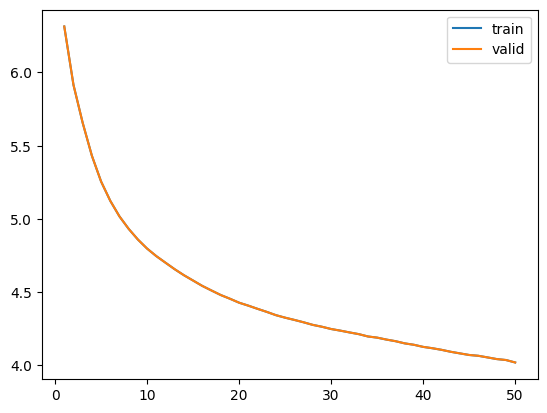

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='valid')
plt.show()




## Definir modelo GRU

In [ ]:
model_gru = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model_gru.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model_gru.add(GRU(64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(64)) # La última capa LSTM no lleva return_sequences
model_gru.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model_gru.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model_gru.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 5)             29355     
                                                                 
 gru (GRU)                   (None, 25, 64)            13632     
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5871)              193743    
                                                                 
Total params: 263770 (1.01 MB)
Trainable params: 26377

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist_gru = model_gru.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
3188/3188 [==============================] - ETA: 0s - loss: 6.4258
 mean perplexity: 742.5692865047273 

3188/3188 [==============================] - 280s 86ms/step - loss: 6.4258
Epoch 2/50
3188/3188 [==============================] - ETA: 0s - loss: 6.2088
 mean perplexity: 654.1818928893441 

3188/3188 [==============================] - 265s 83ms/step - loss: 6.2088
Epoch 3/50
3188/3188 [==============================] - ETA: 0s - loss: 5.7811
 mean perplexity: 639.9027191193981 

3188/3188 [==============================] - 263s 82ms/step - loss: 5.7811
Epoch 4/50
3187/3188 [============================>.] - ETA: 0s - loss: 5.4845
 mean perplexity: 713.1442240577827 

3188/3188 [==============================] - 267s 84ms/step - loss: 5.4845
Epoch 5/50
3188/3188 [==============================] - ETA: 0s - loss: 5.2705
 mean perplexity: 853.2841719165796 

3188/3188 [==============================] - 270s 85ms/step - loss: 5.2705
Epoch 6/50
3187/3188 [==================

<ipython-input-39-4af0c4d597ea>:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

3188/3188 [==============================] - 267s 84ms/step - loss: 4.4282
Epoch 15/50
3188/3188 [==============================] - ETA: 0s - loss: 4.3786
 mean perplexity: inf 

3188/3188 [==============================] - 273s 85ms/step - loss: 4.3786
Epoch 16/50
3187/3188 [============================>.] - ETA: 0s - loss: 4.3397
 mean perplexity: inf 

3188/3188 [==============================] - 273s 86ms/step - loss: 4.3398
Epoch 17/50
3188/3188 [==============================] - ETA: 0s - loss: 4.3080
 mean perplexity: inf 

3188/3188 [==============================] - 269s 84ms/step - loss: 4.3080
Epoch 18/50
3187/3188 [============================>.] - ETA: 0s - loss: 4.2717
 mean perplexity: inf 

3188/3188 [==============================] - 271s 85ms/step - loss: 4.2717
Epoch 19/50
3187/3188 [============================>.] - ETA: 0s - loss: 4.2444
 mean perplexity: inf 

3188/3188 [==============================] - 274s 86ms/step - loss: 4.2444
Epoch

In [ ]:
print(hist_gru.history)

{'loss': [6.425811290740967, 6.208797454833984, 5.781113624572754, 5.484490871429443, 5.270481586456299, 5.102008819580078, 4.966412544250488, 4.851775169372559, 4.757159233093262, 4.675835609436035, 4.603326320648193, 4.536755561828613, 4.478179454803467, 4.428211688995361, 4.3786444664001465, 4.339756488800049, 4.308035850524902, 4.271718978881836, 4.24440860748291, 4.218729019165039, 4.193428993225098, 4.1699137687683105, 4.147136211395264, 4.128719806671143, 4.10889196395874, 4.090348720550537, 4.073612213134766, 4.061048984527588, 4.046428203582764, 4.032506942749023, 4.017273426055908, 4.005133152008057, 3.99658203125, 3.9814372062683105, 3.972137451171875, 3.963351249694824, 3.9538989067077637, 3.940910577774048, 3.9351866245269775, 3.9269466400146484, 3.917565107345581, 3.9106225967407227, 3.9029157161712646, 3.8954107761383057, 3.886730432510376, 3.8812196254730225, 3.8796145915985107, 3.867799997329712, 3.866748094558716, 3.863346815109253]}


Dado a que se ha tardado, vamos a proceder a guardarlo

In [ ]:
# Save the model to a file
import pickle
with open('/content/drive/MyDrive/Maestria/NLP/3model_gru.pkl', 'wb') as f:
    pickle.dump(model_gru, f)
with open('/content/drive/MyDrive/Maestria/NLP/3hist_gru.pkl', 'wb') as f:
    pickle.dump(hist_gru, f)

In [ ]:
# # Load the model from a file
import pickle
with open('/content/drive/MyDrive/Maestria/NLP/3model_gru.pkl', 'rb') as f:
    model_gru = pickle.load(f)
with open('/content/drive/MyDrive/Maestria/NLP/3hist_gru.pkl', 'rb') as f:
    hist_gru = pickle.load(f)

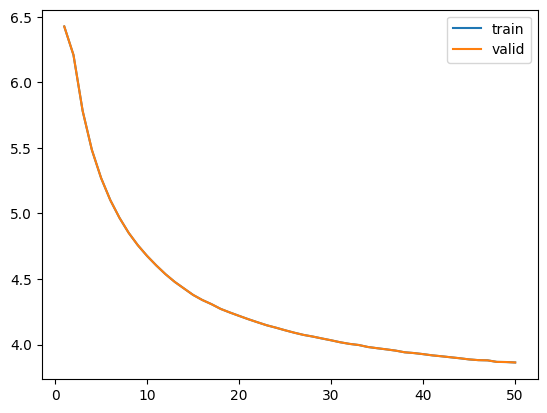

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist_gru.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist_gru.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist_gru.history['loss'], label='valid')
plt.show()

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://fd5dda7a82e44c4959.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 19ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fd5dda7a82e44c4959.gradio.live


## Predicción de próxima palabra

## Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

Probamos ahora para los dos modelos a generar secuencias en base a un input inicial

Para LSTM

In [ ]:
input_text='My product was'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 43ms/step


'My product was not good'

Para GRU

In [ ]:
input_text='I was'

generate_seq(model_gru, tok, input_text, max_length=max_context_size, n_words=5)

1/1 [==============================] - 0s 39ms/step


'I was very disappointed with the taste'

##  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

Usamos beam search para el modelo de LSTM

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=8,input="This product was")

1/1 [==============================] - 0s 24ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

["this product was a waste of money i won't buy them"]

Ahora probamos con GRU

In [ ]:
# predicción con beam search
salidas = beam_search(model_gru,num_beams=10,num_words=8,input="This product was")

1/1 [==============================] - 0s 24ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['this product was not good and did not taste like my']

## Conclusiones


- Ambos modelos, LSTM y GRU, generaron palabras coherentes y relevantes para las oraciones de entrada.
- Da la sensación que el modelo LSTM tuvo un mejor desempeño general, generando oraciones más fluidas y gramaticalmente correctas.
- La estrategia de beam search mejoró la calidad de las oraciones generadas al considerar múltiples opciones.
- Se puede continuar la investigación explorando hiperparámetros: Experimentar con diferentes cantidad de capas, embedings.